## Imports
---

In [43]:
import pandas as pd 
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from src.heikin_ashi import heikin_ashi
from src.indicators import supertrend, VWAP2, smc, atr

## Getting the Data
---

In [3]:
data2 = pd.read_csv("./BTCUSDT-3m-2023-05-04.csv")
data2['Opent'] = pd.to_datetime(data2['Opent'], unit='ms')
data2['Opent'] = pd.to_datetime(data2['Opent'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
data2.set_index('Opent', inplace=True)

## Polygon API
---

In [ ]:
#import modules
from polygon import RESTClient
import datetime as dt

polygonAPIkey = 'n5WUioGpm5YNuvJ0Bfn_No8nQHdfn_eP'
client = RESTClient(api_key=polygonAPIkey)

def getData(ticker, timespan, start, end):
    bars = client.get_aggs(ticker=ticker, multiplier=3, timespan=timespan, from_=start, to=end)
    print(len(bars))


    #list of polygon OptionsContract objects to DataFrame
    downloadedData = pd.DataFrame(bars)

    #create Date column
    downloadedData['Date'] = pd.to_datetime(downloadedData['timestamp'], unit='ms')
    downloadedData['Date'] = pd.to_datetime(downloadedData['Date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
    downloadedData.set_index('Date', inplace=True)

    #drop unnecessary columns
    downloadedData = downloadedData.drop(['vwap', 'transactions', 'otc'], axis=1)
    downloadedData = downloadedData.rename(columns={"open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volume"})

    return downloadedData

data3 = getData("C:EURUSD", "minute", "2022-03-20", "2022-05-08")
data3.iloc[0:30]

1677


,Open,High,Low,Close,Volume,timestamp
Date,,,,,,
2022-03-20 20:00:00,1.10602,1.10602,1.10602,1.10602,1,1647806400000
2022-03-20 20:24:00,1.10602,1.10602,1.10602,1.10602,1,1647807840000
2022-03-20 20:51:00,1.10602,1.10602,1.10602,1.10602,1,1647809460000
2022-03-20 21:00:00,1.10602,1.10602,1.10561,1.10570,10,1647810000000
2022-03-20 21:03:00,1.10570,1.10570,1.10561,1.10569,11,1647810180000
2022-03-20 21:06:00,1.10567,1.10569,1.10564,1.10568,10,1647810360000
2022-03-20 21:15:00,1.10580,1.10580,1.10565,1.10565,3,1647810900000
2022-03-20 21:18:00,1.10570,1.10580,1.10570,1.10570,6,1647811080000
2022-03-20 21:24:00,1.10568,1.10570,1.10568,1.10568,10,1647811440000


In [ ]:
import os
import pandas as pd
import datetime as dt
import time
from polygon import RESTClient

polygonAPIkey = 'n5WUioGpm5YNuvJ0Bfn_No8nQHdfn_eP'
client = RESTClient(api_key=polygonAPIkey)

def downloadAllData(ticker, timespan, start, end, csv_directory):
    current_start = start
    cumulative_data = pd.DataFrame()

    while current_start < end:
        current_end = min(current_start + pd.DateOffset(days=3), end)
        data = getData(ticker, timespan, current_start, current_end)

        if not data.empty:
            # Create directory if it doesn't exist
            os.makedirs(csv_directory, exist_ok=True)

            # Save data for the current day
            csv_file = os.path.join(csv_directory, f"{current_start.strftime('%Y-%m-%d')}.csv")
            data.to_csv(csv_file)

            # Append data to cumulative dataframe
            cumulative_data = pd.concat([cumulative_data, data])

            print(f"Downloaded data for {current_start} to {current_end}")

        current_start = current_end + pd.DateOffset(days=1)
        time.sleep(61)

    # Save cumulative data to a cumulative CSV file
    cumulative_csv_file = os.path.join(csv_directory, "cumulative_data.csv")
    cumulative_data.to_csv(cumulative_csv_file)

    return cumulative_data

# Example usage
end_date = dt.datetime.now().date()
start_date = end_date - dt.timedelta(days=365)
csv_directory = "data_directory"

data = downloadAllData("C:EURUSD", "minute", start_date, end_date, csv_directory)
print(data.head())
print(data.tail())

## The Smart Money Concept Order Block Indicator
---

    1:15 oben -> 25
    1:27 unten -> 29
    4:33 oben -> 91
    5:09 unten -> 103
    6:00 oben -> 120
    6:57 oben -> 139
    8:09 oben -> 163
    8:15 unten -> 165
    10:09 unten -> 203
    11:12 oben -> 224
    12:06 oben -> 243
    13:06 oben -> 263
    14:06 unten -> 283
    16:03 unten -> 321
    17:00 unten -> 340
    17:18 oben -> 346
    18:06 oben -> 362
    18:39 oben -> 373
    19:15 unten -> 385
    19:42 unten -> 394
    20:00 oben -> 400
    21:06 oben -> 422
    21:42 oben -> 434
    23:45 unten -> 475

    13  28950.98
    29  28975.0 JA
    59  28991.35
    103  29057.82 JA
    131  29090.56 JA
    165  28982.58 JA
    174  29032.07
    191  29035.26
    273  28663.64
    321  28795.01
    370  28673.59
    427  28784.25
    445  28748.0

## The Strategy
---

In [30]:
forex_data = pd.read_csv("./data_directory/cumulative_data.csv")
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'], unit='ms')
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
forex_data.set_index('timestamp', inplace=True)
forex_data

,Date,Open,High,Low,Close,Volume
timestamp,,,,,,
2022-05-12 00:00:00,2022-05-12 00:00:00,1.05118,1.05132,1.0509,1.05118,383
2022-05-12 00:03:00,2022-05-12 00:03:00,1.05116,1.05130,1.0509,1.05124,411
2022-05-12 00:06:00,2022-05-12 00:06:00,1.05110,1.05141,1.0511,1.05120,395
2022-05-12 00:09:00,2022-05-12 00:09:00,1.05118,1.05130,1.0508,1.05100,371
2022-05-12 00:12:00,2022-05-12 00:12:00,1.05101,1.05134,1.0508,1.05132,405
...,...,...,...,...,...,...
2023-05-11 23:45:00,2023-05-11 23:45:00,1.09110,1.09140,1.0911,1.09133,164
2023-05-11 23:48:00,2023-05-11 23:48:00,1.09135,1.09140,1.0912,1.09132,119
2023-05-11 23:51:00,2023-05-11 23:51:00,1.09136,1.09140,1.0911,1.09120,127


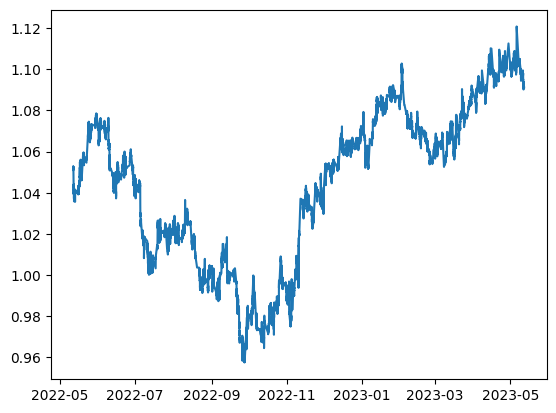

In [53]:
plt.plot(heikin_ashi(forex_data)['Close'])

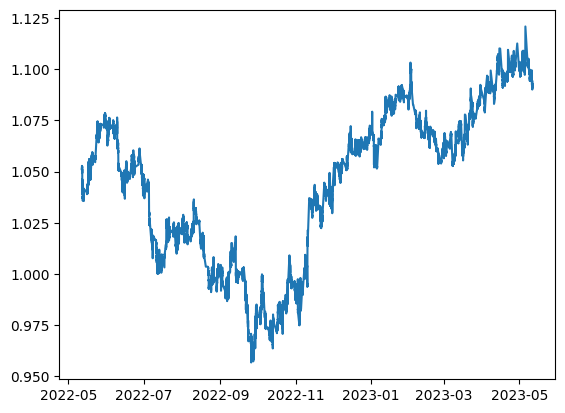

In [54]:
plt.plot(forex_data['Close'])

In [24]:
forex_data

,Date,Open,High,Low,Close,Volume,timestamp
0,2022-05-12 00:00:00,1.05118,1.05132,1.0509,1.05118,383,1652313600000
1,2022-05-12 00:03:00,1.05116,1.05130,1.0509,1.05124,411,1652313780000
2,2022-05-12 00:06:00,1.05110,1.05141,1.0511,1.05120,395,1652313960000
3,2022-05-12 00:09:00,1.05118,1.05130,1.0508,1.05100,371,1652314140000
4,2022-05-12 00:12:00,1.05101,1.05134,1.0508,1.05132,405,1652314320000
...,...,...,...,...,...,...,...
94659,2023-05-11 23:45:00,1.09110,1.09140,1.0911,1.09133,164,1683848700000
94660,2023-05-11 23:48:00,1.09135,1.09140,1.0912,1.09132,119,1683848880000
94661,2023-05-11 23:51:00,1.09136,1.09140,1.0911,1.09120,127,1683849060000
94662,2023-05-11 23:54:00,1.09124,1.09130,1.0911,1.09118,150,1683849240000


In [47]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import talib as tab
class PIES2(Strategy):
    
    def init(self):
        # Store orderblock values
        self.orderblocksU = []
        self.orderblocksB = []
        # If orderblock got hit and price is above/below upperbands/lowerbands
        self.tagged = False
        self.taggedprice = 0
        # Counter of how many candles it was ago when orderblock got tagged
        self.taggedcounter = 0
        # Overall candle count
        self.candlecount = 17
        self.trade_opened = False
        self.stoploss = 0
        self.sholong = 0  #0 stands for long trade and 1 for short trade
        # Values that act as a buffer for the orderblocks after they got hit
        self.orderblocklow = 0
        self.orderblockhigh = 0
        
        # Supertrend Indicator
        self.supertrendu = self.I(supertrend, self.data.df, lookback=10, multiplier=2.5, band=0)
        self.supertrendl = self.I(supertrend, self.data.df, lookback=10, multiplier=2.5, band=1)
        # VWAP Indicator
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        # Orderblock Indicator
        self.upperOB = self.I(smc, self.data.df, length=10, band=1)
        self.lowerOB = self.I(smc, self.data.df, length=10, band=0)
        # ATR Indicator
        self.atr = self.I(tab.ATR, self.data.High, self.data.Low, self.data.Close, 14)

    def next(self):
        # Add orderblocks
        # TODO London time, Heikin Ashi candles on when tagged

        if(self.upperOB[-1] > 0):
            self.orderblocksU.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
        if(self.lowerOB[-1] > 0):
            self.orderblocksB.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
        # If no trade is open
        if not self.trade_opened:
            # If it didnt hit orderblock + upper/lower band yet
            if self.tagged==False:
                # For loops to iterate through the orderblocks and check if they got hit
                for high, low, candle in self.orderblocksU:
                    if self.data.High[-1] > low and self.data.High[-1] < high and ((self.data.High[-1] > self.vwapu2[-1] - self.atr[-1] and self.data.High[-1] < self.vwapu2[-1] + self.atr[-1]) or (self.data.High[-1] > self.vwapu3[-1] - self.atr[-1] and self.data.High[-1] < self.vwapu3[-1] + self.atr[-1])):
                        self.tagged = True
                        self.taggedprice = self.data.High[-1]
                        self.orderblocklow = low
                        self.sholong = 1
                        self.orderblocksU.remove([high, low, candle])
                        break
                for high, low, candle in self.orderblocksB:
                    if self.data.Low[-1] < high and self.data.Low[-1] > low and self.data.Low[-1] < self.vwapl2[-1] * 1:
                        self.tagged = True
                        self.orderblockhigh = high
                        self.sholong = 0
                        self.orderblocksB.remove([high, low, candle])
                        break

            # If it hit and we have to go short
            elif (self.tagged == True and self.sholong == 1):
                if self.taggedcounter < 7:
                    if self.data.High[-1] < self.orderblocklow and self.data.Open[-1] > (self.data.High[-1] - (self.data.High[-1] - self.data.Low[-1]) * 0.15):
                        self.trade_opened = True
                        self.sell(size=.9999)
                        self.stoploss = self.data.High[-1]
                    self.taggedcounter += 1
                else: 
                    self.tagged = False
                    self.taggedcounter = 0
                
            # If it hit and we have to go long
            elif (self.tagged == True and self.sholong == 0):
                if self.taggedcounter < 7:
                    if self.data.Low[-1] > self.orderblockhigh and self.data.Open[-1] < (self.data.Low[-1] + (self.data.High[-1] - self.data.Low[-1]) * 0.15):
                        self.buy(size=0.99)
                        self.trade_opened = True
                        self.stoploss = self.data.Low[-1]
                else: 
                    self.tagged = False
                    self.taggedcounter = 0
                self.taggedcounter += 1


        elif self.trade_opened: # Stop loss path
            if self.sholong == 0:
                if(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0) or self.data.Low[-1] < self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
            elif self.sholong == 1:
                if(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0) or self.data.High[-1] > self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
        self.candlecount = self.candlecount + 1

        
bt2 = Backtest((forex_data), PIES2, cash=100000, commission=0.00, exclusive_orders=True)
# Run the backtest and append the results to the list
output = bt2.run()
output

Start                     2022-05-12 00:00:00
End                       2023-05-11 23:57:00
Duration                    364 days 23:57:00
Exposure Time [%]                    14.51555
Equity Final [$]                  99233.27379
Equity Peak [$]                  103258.32138
Return [%]                          -0.766726
Buy & Hold Return [%]                 3.80715
Return (Ann.) [%]                   -0.649267
Volatility (Ann.) [%]                3.087794
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                    -4.90956
Avg. Drawdown [%]                   -0.205016
Max. Drawdown Duration      308 days 10:45:00
Avg. Drawdown Duration        7 days 07:07:00
# Trades                                  846
Win Rate [%]                        27.541371
Best Trade [%]                       1.725377
Worst Trade [%]                     -0.366232
Avg. Trade [%]                    

In [48]:
bt2.plot()

/Users/dennisschielke/Library/Python/3.9/lib/python/site-packages/backtesting/_plotting.py:122: UserWarning: Data contains too many candlesticks to plot; downsampling to '1H'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
/Users/dennisschielke/Library/Python/3.9/lib/python/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/dennisschielke/Library/Python/3.9/lib/python/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p9366', ...)